# Titanic Dataset Analysis with Random Forest Classifier

#### The titanic data set is separated into a training set and a test set. The training set is used here to build a random forest classifier model and test set is used to measure model quality.

In [1]:
import pandas as pd
import seaborn as sns
import math
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
sns.set(style='white')
sns.color_palette('bright', 8)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lato-Regular']

In [3]:
X_full = pd.read_csv('train.csv')
X_test_full = pd.read_csv('test.csv')

#### Each ```.csv``` file contains missing values for different features. For example, some entries lack an 'Age' value. Thus, they have to be filled in accordingly. Which values require filling? We can write a function that displays this information.

In [4]:
def show_missing_values(X_full, X_test_full):
    #Checking training set
    print('Training Set:')
    for fname in X_full.columns:
        if X_full[fname].isna().values.any():
            print(fname, 'contains missing values')

    #Checking test set
    print()
    print('Test Set:')
    for fname in X_test_full.columns:
        if X_test_full[fname].isna().values.any():
            print(fname, 'contains missing values')

In [5]:
show_missing_values(X_full, X_test_full)

Training Set:
Age contains missing values
Cabin contains missing values
Embarked contains missing values

Test Set:
Age contains missing values
Fare contains missing values
Cabin contains missing values


#### The missing values in Age and Fare can be filled using statistical measures. Because the value of cabin is unique for each passenger, it is impossible to predict statistically which cabin was occupied by which passenger (this will require feature engineering). Once we know which features are highly correlated with each other, we can decide how to fill in the missing values in. For the embarked feature, we use previously known survival data.

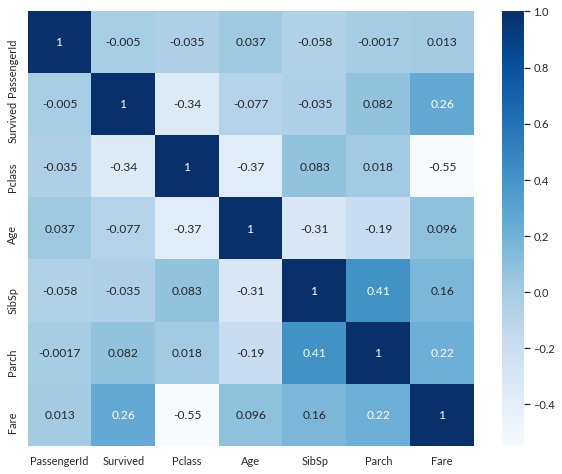

In [6]:
#We start with the training set
plt.figure(figsize=(10,8))
correlation = X_full.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Blues)

#### Age is most strongly correlated with Pclass so we can group passengers by Pclass and fill in missing ages by considering the mean age of each Pclass.

In [7]:
train_age_df = X_full.groupby(['Sex', 'Pclass']).mean()['Age'] #gets the mean age of men and women in each Pclass
for index, row in X_full.iterrows():
    #If we find an age that has a missing value, find the corresponding Sex and Pclass entry and fill it.
    if math.isnan(row['Age']):
        X_full.at[index, 'Age'] = train_age_df[row['Sex']][row['Pclass']]

#### For the embaked feature, we know from [this link](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) that the missing value should be filled with Southampton or S.

In [8]:
X_full['Embarked'] = X_full['Embarked'].fillna('S')

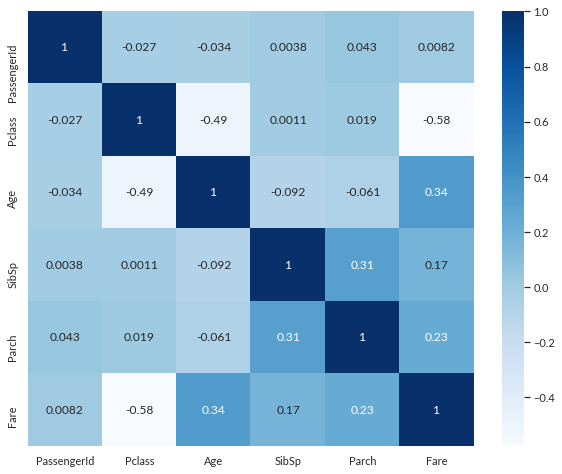

In [9]:
#Test set
plt.figure(figsize=(10,8))
correlation = X_test_full.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Blues)

#### For the test set, we again see that Age is highly correlated with Pclass, so we follow the same prescription.

In [10]:
test_age_df = X_test_full.groupby(['Sex', 'Pclass']).mean()['Age'] #gets the mean age of men and women in each Pclass
for index, row in X_test_full.iterrows():
    #If we find an age that has a missing value, find the corresponding Sex and Pclass entry and fill it.
    if math.isnan(row['Age']):
        X_test_full.at[index, 'Age'] = test_age_df[row['Sex']][row['Pclass']]

#### Fare is also highly correlated with Pclass!

In [11]:
test_fare_df = X_test_full.groupby(['Sex', 'Pclass']).mean()['Fare'] #gets the mean age of men and women in each Pclass
for index, row in X_test_full.iterrows():
    #If we find an age that has a missing value, find the corresponding Sex and Pclass entry and fill it.
    if math.isnan(row['Fare']):
        X_test_full.at[index, 'Fare'] = test_fare_df[row['Sex']][row['Pclass']]

#### We can check that these code blocks have done the right thing by calling show_missing_values() again.

In [12]:
show_missing_values(X_full, X_test_full)

Training Set:
Cabin contains missing values

Test Set:
Cabin contains missing values


#### For the cabin feature, much of it is missing. But we can use feature engineering to solve this problem. Historically, the higher deck letter, the more affluent the citizen (smaller Pclass number) and closer they were to the surface deck (easier time getting out/escaping). For simplicity, we will assume that first class citizens stayed in cabins A, B, and C. Second class citizens occupied cabins D and E. And third class citizens occupied cabins F and G. If there is a 'nan' value for the passenger, we label it as M. 

In [13]:
deck_list = []
for _, row in X_full.iterrows():
    if (type(row['Cabin']) == float):
        deck_list.append('M')
    else:
        if row['Pclass'] == 1:
            deck_list.append('ABC')
        elif row['Pclass'] == 2:
            deck_list.append('DE')
        elif row['Pclass'] == 3:
            deck_list.append('FG')
deck_df = pd.DataFrame(data=deck_list, columns=['Deck'])

#Drop the cabin feature because it is no longer required
X_full_no_cabin = X_full.drop(['Cabin'], axis=1)

#Concatenate the deck_df and X_full_no_cabin back into X_full
X_full = pd.concat([X_full_no_cabin, deck_df], axis=1)

#### Perform a similar operation on the test data.

In [14]:
deck_list = []
for _, row in X_test_full.iterrows():
    if (type(row['Cabin']) == float):
        deck_list.append('M')
    else:
        if row['Pclass'] == 1:
            deck_list.append('ABC')
        elif row['Pclass'] == 2:
            deck_list.append('DE')
        elif row['Pclass'] == 3:
            deck_list.append('FG')
deck_df = pd.DataFrame(data=deck_list, columns=['Deck'])

#Drop the cabin feature because it is no longer required
X_test_full_no_cabin = X_test_full.drop(['Cabin'], axis=1)

#Concatenate the deck_df and X_full_no_cabin back into X_full
X_test_full = pd.concat([X_test_full_no_cabin, deck_df], axis=1)

#### To visually see how the new deck feature could potentetially lead to better model accuracy, we can make a count plot.

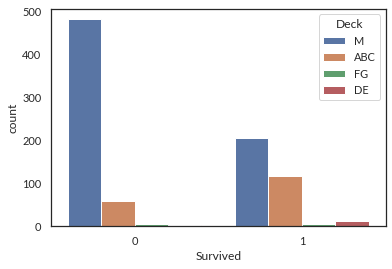

In [15]:
sns.countplot('Survived', hue=X_full['Deck'], data=X_full)

#### A significant number of those in the "M" deck did not survive, which is most certainly helpful in predicting survival rate.

#### Again, we see if there are any missing values in each data set.

In [16]:
show_missing_values(X_full, X_test_full)

Training Set:

Test Set:


#### There are none! This means we no longer have to fill in any values, but we most certainly can generate new features. We haven't looked at the name column yet; it could contain some important information on survival rate. Fittingly enough, we can extract titles from each name in the data set (Mr., Mrs., Miss, Dr., etc.). Also, we change all titles to english.

In [17]:
title_list = []
for _, row in X_full.iterrows():
    name = row['Name'].split()
    for e in name:
        title = re.match('([A-Z][a-z]+)\.', e)
        if title != None:
            title_list.append(title.group(1))
X_full['Title'] = title_list

#### Make the appropriate changes in the test data too.

In [18]:
title_list = []
for _, row in X_test_full.iterrows():
    name = row['Name'].split()
    for e in name:
        title = re.match('([A-Z][a-z]+)\.', e)
        if title != None:
            title_list.append(title.group(1))
X_test_full['Title'] = title_list

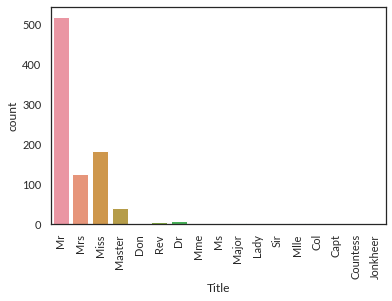

In [19]:
sns.countplot(x='Title', data=X_full);
plt.xticks(rotation=90);

#### As seen above there are a number of "special" titles as well as titles that mean the same thing, yet are spelled differently (e.g. Ms and Miss). We can make the appropriate substitutions here.

In [20]:
X_full['Title'] = X_full['Title'].replace(['Mlle'], 'Miss')
X_full['Title'] = X_full['Title'].replace(['Ms', 'Mme'], 'Mrs')
X_full['Title'] = X_full['Title'].replace(['Don', 'Jonkheer', 'Sir', 'Countess', 'Lady'], 'Royal')
X_full['Title'] = X_full['Title'].replace(['Rev', 'Dr', 'Major', 'Col', 'Capt'], 'Upper')

#### Evidently, title is a feature that can be used for prediction. We use the same prescription on the test set.

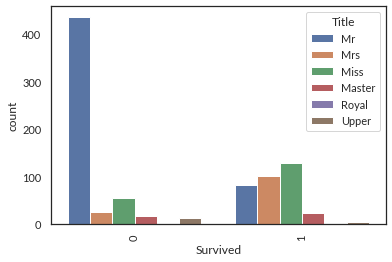

In [21]:
sns.countplot('Survived', hue=X_full['Title'], data=X_full);
plt.xticks(rotation=90);

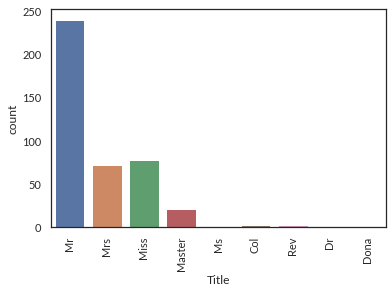

In [22]:
sns.countplot(x='Title', data=X_test_full);
plt.xticks(rotation=90);

In [23]:
X_test_full['Title'] = X_test_full['Title'].replace(['Ms'], 'Miss')
X_test_full['Title'] = X_test_full['Title'].replace(['Col', 'Dr', 'Rev'], 'Upper') 
X_test_full['Title'] = X_test_full['Title'].replace(['Dona'], 'Royal')

#### We create one more feature Family_Size which is the total family size for each individual passenger. Having a larger family could lend itself to greater difficulty in securing life boats, and thus, reduces survival.

In [24]:
X_full['Family_Size'] = X_full['SibSp'] + X_full['Parch'] + 1
X_test_full['Family_Size'] = X_test_full['SibSp'] + X_test_full['Parch']

#### The family size certainly has an effect on the survival rate as seen below.

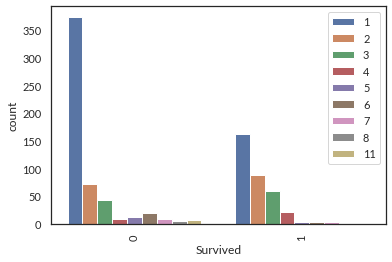

In [25]:
sns.countplot('Survived', hue=X_full['Family_Size'], data=X_full);
plt.legend(loc='upper right')
plt.xticks(rotation=90);

#### Finally, we drop columns that no longer contribute to the data sets.

In [26]:
print(X_full.columns)
print(X_test_full.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck', 'Title', 'Family_Size'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Deck', 'Title', 'Family_Size'],
      dtype='object')


In [27]:
X_full = X_full.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

#We will need PassengerId for the submission, so we keep it in a separate data frame
passengerId_df = X_test_full['PassengerId']
X_test_full = X_test_full.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

#### Extract the target data from the training data.

In [28]:
y = X_full['Survived']
X_full = X_full.drop(['Survived'], axis=1)

#### Because the data is now completely clean, we build our model. First, we split the training data into training and validation data.

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

In [30]:
print(X_train)

     Pclass     Sex        Age  SibSp  Parch     Fare Embarked Deck Title  \
140       3  female  21.750000      0      2  15.2458        C    M   Mrs   
439       2    male  31.000000      0      0  10.5000        S    M    Mr   
817       2    male  31.000000      1      1  37.0042        C    M    Mr   
378       3    male  20.000000      0      0   4.0125        C    M    Mr   
491       3    male  21.000000      0      0   7.2500        S    M    Mr   
..      ...     ...        ...    ...    ...      ...      ...  ...   ...   
835       1  female  39.000000      1      1  83.1583        C  ABC  Miss   
192       3  female  19.000000      1      0   7.8542        S    M  Miss   
629       3    male  26.507589      0      0   7.7333        Q    M    Mr   
559       3  female  36.000000      1      0  17.4000        S    M   Mrs   
684       2    male  60.000000      1      1  39.0000        S    M    Mr   

     Family_Size  
140            3  
439            1  
817            3  

#### Because we have categorical data (Sex, Embarked, etc.) that does not have numerical values, we need to one-hot-encode the training and validation data such that it is numerical.

In [31]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

#Get encoded values of each categorical feature
pclass_encoded = pd.get_dummies(X_train['Pclass'], prefix='Pclass')
sex_encoded = pd.get_dummies(X_train['Sex'], prefix='Sex')
embarked_encoded = pd.get_dummies(X_train['Embarked'], prefix='Embarked')
deck_encoded = pd.get_dummies(X_train['Deck'], prefix='Deck')
title_encoded = pd.get_dummies(X_train['Title'], prefix='Title')

X_train_encoded = pd.concat([X_train, pclass_encoded, sex_encoded, embarked_encoded, deck_encoded, title_encoded], axis=1)
X_train = X_train_encoded.drop(categorical_features, axis=1)

In [32]:
#Get encoded values of each categorical feature
pclass_encoded = pd.get_dummies(X_valid['Pclass'], prefix='Pclass')
sex_encoded = pd.get_dummies(X_valid['Sex'], prefix='Sex')
embarked_encoded = pd.get_dummies(X_valid['Embarked'], prefix='Embarked')
deck_encoded = pd.get_dummies(X_valid['Deck'], prefix='Deck')
title_encoded = pd.get_dummies(X_valid['Title'], prefix='Title')

X_valid_encoded = pd.concat([X_valid, pclass_encoded, sex_encoded, embarked_encoded, deck_encoded, title_encoded], axis=1)
X_valid = X_valid_encoded.drop(categorical_features, axis=1)

#### Now, we fit our random forest classifier model including tuning the model.

In [33]:
rf_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1700,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=44,
                                           n_jobs=-1,
                                           verbose=0)

In [34]:
params = dict(
    max_depth = [n for n in range(6, 9)],     
    min_samples_split = [n for n in range(6, 8)], 
    min_samples_leaf = [n for n in range(5, 7)],
)

In [35]:
rf_model_cv = GridSearchCV(estimator=rf_model, param_grid=params, cv=5)

In [36]:
rf_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1700, n_jobs=-1,
                                              oob_score=True, random_state=44),
             param_grid={'max_depth': [6, 7, 8], 'min_samples_leaf': [5, 6],
                         'min_samples_split': [6, 7]})

In [37]:
print("Best score: {}".format(rf_model_cv.best_score_))
print("Optimal params: {}".format(rf_model_cv.best_estimator_))

Best score: 0.8272530286614794
Optimal params: RandomForestClassifier(max_depth=6, min_samples_leaf=5, min_samples_split=6,
                       n_estimators=1700, n_jobs=-1, oob_score=True,
                       random_state=44)


#### This model has a score of about 84% which is fairly accurate. We can then use this model to make predictions using the test data.

In [38]:
print(X_test_full)

     Pclass     Sex        Age  SibSp  Parch      Fare Embarked Deck   Title  \
0         3    male  34.500000      0      0    7.8292        Q    M      Mr   
1         3  female  47.000000      1      0    7.0000        S    M     Mrs   
2         2    male  62.000000      0      0    9.6875        Q    M      Mr   
3         3    male  27.000000      0      0    8.6625        S    M      Mr   
4         3  female  22.000000      1      1   12.2875        S    M     Mrs   
..      ...     ...        ...    ...    ...       ...      ...  ...     ...   
413       3    male  24.525104      0      0    8.0500        S    M      Mr   
414       1  female  39.000000      0      0  108.9000        C  ABC   Royal   
415       3    male  38.500000      0      0    7.2500        S    M      Mr   
416       3    male  24.525104      0      0    8.0500        S    M      Mr   
417       3    male  24.525104      1      1   22.3583        C    M  Master   

     Family_Size  
0              0  
1

#### Again, we must one-hot-encode the test set.

In [39]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

#Get encoded values of each categorical feature
pclass_encoded = pd.get_dummies(X_test_full['Pclass'], prefix='Pclass')
sex_encoded = pd.get_dummies(X_test_full['Sex'], prefix='Sex')
embarked_encoded = pd.get_dummies(X_test_full['Embarked'], prefix='Embarked')
deck_encoded = pd.get_dummies(X_test_full['Deck'], prefix='Deck')
title_encoded = pd.get_dummies(X_test_full['Title'], prefix='Title')

X_test_encoded = pd.concat([X_test_full, pclass_encoded, sex_encoded, embarked_encoded, deck_encoded, title_encoded], axis=1)
X_test = X_test_encoded.drop(categorical_features, axis=1)

#### Finally, we make predictions and save them to a ```.csv```

In [40]:
test_predictions = rf_model_cv.predict(X_test)
output = pd.DataFrame({'PassengerId': passengerId_df,
                       'Survived': test_predictions})
output.to_csv('submission.csv', index=False)

## This model scored about 79% accuracy in the Kaggle competition which is about 78th percentile.